In [1]:
import time
from pathlib import Path
import requests
from fastai.vision.all import *
from fastcore.all import *
from fastai.vision.core import PILImage

images_down = True

def fetch_image_urls(query, num_images=5, api_key='YOUR_API_KEY'):
    url = f"https://api.openverse.org/v1/images/?q={query}&format=json&page_size={num_images}"
    headers = {
        'Authorization': f'ApiKey {api_key}',
        'Content-Type': 'application/json'
    }
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        data = response.json()
        return [result['url'] for result in data['results']]
    else:
        print(f"Failed to retrieve images. Status code: {response.status_code}")
        return []

def download_bear_images(bear_types, path, num_images=150, batch_size=5, api_key='YOUR_API_KEY'):
    path.mkdir(exist_ok=True)
    for bear_type in bear_types:
        dest = path / bear_type
        dest.mkdir(exist_ok=True)
        all_urls = []
        for page in range(0, num_images, batch_size):
            print(f"Fetching {bear_type} images {page+1}-{min(page+batch_size, num_images)}...")
            urls = fetch_image_urls(bear_type, num_images=batch_size, api_key=api_key)
            all_urls.extend(urls)
            time.sleep(1)  # To respect rate limits
        download_images(dest, urls=all_urls)
        print(f"Downloaded {len(all_urls)} images for {bear_type}.")

bear_types = ['grizzly bear', 'black bear', 'teddy bear']
path = Path('bears')
if not images_down:
    download_bear_images(bear_types, path)

In [2]:
#quick notes on above, kept getting rate limited by OpenVerse even with an API key.
#So this now downloads the pictures 5 at a time.

In [3]:
# Next we're going to clean our data by removing failed images

In [4]:
fns = get_image_files(path)
fns

(#477) [Path('bears/teddy bear/e356dc2e-631b-4b67-b4c9-e360e0421185.jpg'),Path('bears/teddy bear/7c1e7acd-e65a-410f-9199-eedde594abab.jpg'),Path('bears/teddy bear/34288bec-360a-4dd0-b817-bf1e433387d3.jpg'),Path('bears/teddy bear/220201bb-75f4-4e23-a60c-7ad81e468630.jpg'),Path('bears/teddy bear/c504cb65-0f2c-4ffe-b4f9-531818d83af0.jpg'),Path('bears/teddy bear/a3355286-29df-4f62-b373-0d0b763b9ee9.jpg'),Path('bears/teddy bear/5a23ebc3-e177-4b37-af27-01ddb59a47c3.jpg'),Path('bears/teddy bear/d42bfc88-edb3-4ae9-9e12-5daf7363a0eb.jpg'),Path('bears/teddy bear/8d58cde8-efab-4664-bf2c-e6055be212c5.jpg'),Path('bears/teddy bear/76496bb4-ca58-42c4-9bff-69a507e88c3f.jpg'),Path('bears/teddy bear/093c7618-e2d1-4459-8dc8-3935e36cc31b.jpg'),Path('bears/teddy bear/e6159d8d-ee4b-4148-aef5-f516505509b8.jpg'),Path('bears/teddy bear/bd6131eb-dfdd-4268-a1f8-35e21e6e543c.jpg'),Path('bears/teddy bear/25e2718b-d522-4281-b374-40488673caf1.jpg'),Path('bears/teddy bear/a725f9a1-44a8-471a-8ab2-6aa360597e72.jpg'),Pa

In [5]:
failed = verify_images(fns)
failed

(#0) []

In [6]:
failed.map(Path.unlink);

In [7]:
# You can use this command in Jupyter to find info about a function
??verify_images

Signature: verify_images(fns)
Source:   
def verify_images(fns):
    "Find images in `fns` that can't be opened"
    return L(fns[i] for i,o in enumerate(parallel(verify_image, fns)) if not o)
File:      ~/miniforge3/envs/fastai/lib/python3.12/site-packages/fastai/vision/utils.py
Type:      function

In [8]:
??get_image_files

Signature: get_image_files(path, recurse=True, folders=None)
Source:   
def get_image_files(path, recurse=True, folders=None):
    "Get image files in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=image_extensions, recurse=recurse, folders=folders)
File:      ~/miniforge3/envs/fastai/lib/python3.12/site-packages/fastai/data/transforms.py
Type:      function

In [9]:
# remember we're going to set the path later
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [10]:
dls = bears.dataloaders(path)

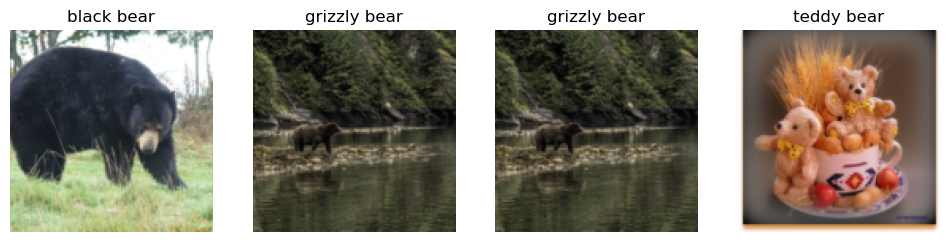

In [11]:
dls.valid.show_batch(max_n=4, nrows=1)

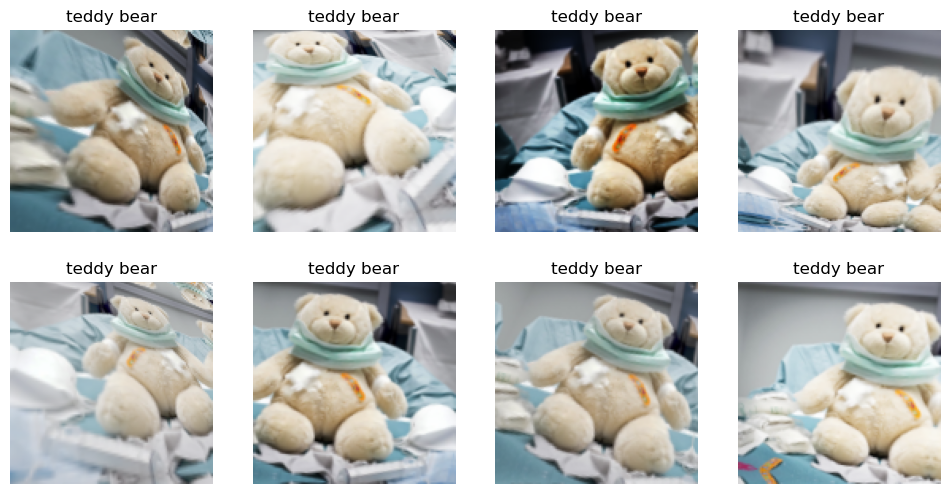

In [12]:
# Here's some of the transform craziness you can do:
# multiplied by 2 to make it more obvious
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

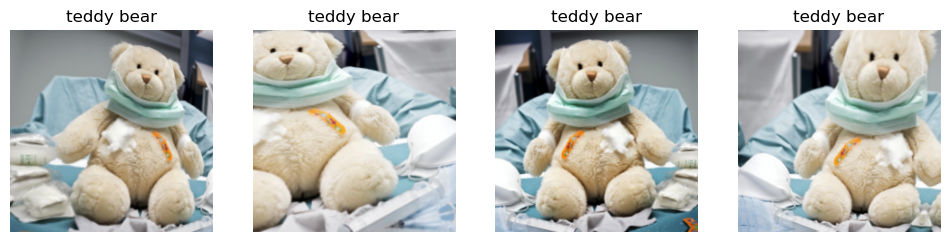

In [13]:
#In our real model we're just going to use RandomResizedCrop
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [14]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.306824,0.126262,0.010526,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.101628,0.039261,0.010526,00:02
1,0.080032,0.055644,0.010526,00:02
2,0.071700,0.047451,0.010526,00:02
3,0.063246,0.041287,0.010526,00:02


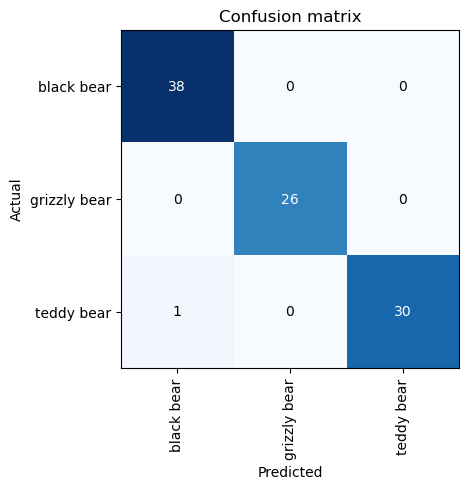

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
#This shows us our incorrectly labeled tests.
#We can actually correct the wrong ones

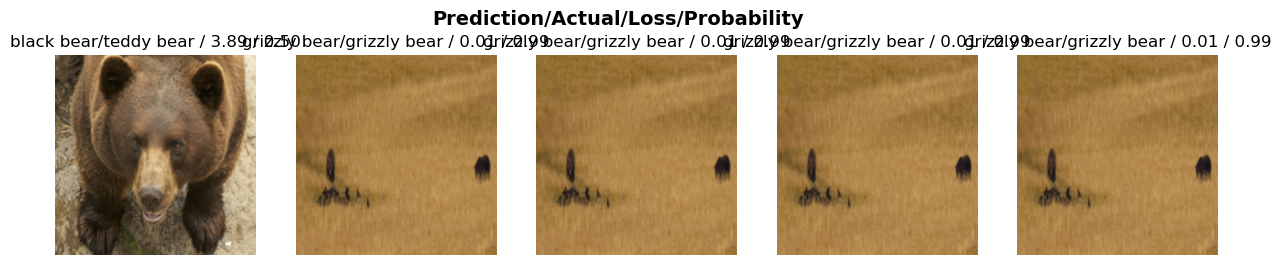

In [16]:
interp.plot_top_losses(5, nrows=1)

In [17]:

from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

In [18]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [19]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [20]:
learn.export()

In [21]:
#Now we can use the export.pkl file to upload our model other places.
#we're going to show how to do inference on a loaded model here
# usually this would be for loading a model we didn't JUST create

In [24]:
learn_inf = load_learner('export.pkl')

In [26]:
learn_inf.predict('grizzly.jpeg')

('grizzly bear', tensor(1), tensor([2.0023e-02, 9.7954e-01, 4.3664e-04]))

In [27]:
#if we want to see the categories
learn_inf.dls.vocab

['black bear', 'grizzly bear', 'teddy bear']